In [ ]:
''' This particular notebook deals with creating the plots for the trends between the hyperbola fitting 
parameter k, and the values collected from the survey results. It reads the Patience Measures and the 
collected Participant information, and draws its plots to the Trends subfolder.
Created by: Aishwarya Seth
Created on: April 16th, 2022'''

In [1]:
# All relevant imports
import pandas as pd
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
from scipy import optimize
from matplotlib.backends.backend_pdf import PdfPages


In [2]:
# Read in the bootstrapped estimates
files = glob.glob("./ParticipantEstimates/*")

In [3]:
df_info = pd.read_csv('./../Combined_Data/ParticipantInfo.csv')

In [4]:
df_estimates = pd.read_csv('./PatienceMeasures.csv')

In [5]:
# Merges together all bootstrapped estimates -- this code could be modified to generate trends on the basis 
# of these bootstrapped estimates
df_bootstrap_estimates = pd.DataFrame()
count = 0
for file in files:
    if(count == 0):
        df_bootstrap_estimates = pd.read_csv(file)
        count = count + 1
    else:
        df_bootstrap_estimates = df_bootstrap_estimates.append(pd.read_csv(file).iloc[0])

In [6]:
# Merge together the survey results and fitting parameters
merge = pd.merge(df_info, df_estimates, on = 'RefID')
merge['Degree'] = pd.Categorical(merge['Degree'], ["Undergraduate", "Masters", "PhD"])

In [7]:
merge = merge.sort_values(by = ['Degree', 'Age'])
print(merge[['RefID','Age', 'Degree', 'Fitting_Param_k', 'Fitting_Param_m', 'Fitting_Param_Beta', 'Fitting_Param_Delta']])

   RefID  Age         Degree  Fitting_Param_k  Fitting_Param_m  \
1      2   20  Undergraduate     7.157136e-03     8.345341e-01   
5      6   20  Undergraduate     1.040699e-02     5.271457e-01   
7      8   20  Undergraduate     5.366571e-02     7.620462e-01   
9     10   20  Undergraduate     9.956312e-02     1.000000e+00   
0      1   21  Undergraduate     1.789781e-02     4.109163e-01   
2      3   22  Undergraduate     1.000000e+00     1.000000e+00   
8      9   26        Masters     5.065275e-02     1.000000e+00   
4      5   23            PhD     3.770000e-15     2.390000e-21   
6      7   23            PhD     1.870000e-10     1.222454e-01   
3      4   24            PhD     6.211139e-02     6.711203e-01   

   Fitting_Param_Beta  Fitting_Param_Delta  
1            0.007910             0.007910  
5            0.010393             0.010392  
7            0.164544             0.004983  
9            0.040283             0.119589  
0            0.014134             0.014134  
2  

In [8]:
# Merge together the survey results and bootstrapped parameters
merge_bootstrap = pd.merge(df_info, df_bootstrap_estimates, on  = 'RefID')
merge['Degree'] = pd.Categorical(merge['Degree'], ["Undergraduate", "Masters", "PhD"])

In [9]:
merge_bootstrap = merge_bootstrap.sort_values(by = ['Degree', 'Age'])
print(merge_bootstrap[['Age', 'Degree', 'k_est', 'm_est', 'beta_est', 'delta_est']])

   Age         Degree         k_est         m_est  beta_est  delta_est
8   26        Masters  6.412353e-02  9.933664e-01  0.062983   0.054614
4   23            PhD  7.978094e-12  1.549603e-14 -0.033139  -0.033139
6   23            PhD  1.414659e-03  1.043413e-01 -0.013377  -0.013377
3   24            PhD  6.658289e-02  7.494027e-01  0.149520   0.161610
1   20  Undergraduate  7.462654e-03  6.204357e-01 -0.002519  -0.002519
5   20  Undergraduate  1.073694e-02  4.649686e-01 -0.000756  -0.000759
7   20  Undergraduate  6.039526e-02  7.927935e-01  0.108516   0.108509
9   20  Undergraduate  1.278261e-01  1.000000e+00  0.142982   0.135574
0   21  Undergraduate  1.995619e-02  4.276109e-01  0.034176   0.030834
2   22  Undergraduate  9.935216e-01  1.000000e+00  0.855290   0.844644


In [10]:
# Definition of a linear function -- used later in the code for curve fitting
def linear(x, m, c):
    return (m * x + c)

In [11]:
# Function for creating a linear trend for a given survey-obtained factor and the estimated parameter k
# Plots created by these functions are stored in the 'Trends' folder
def linear_fit(df, factor, parameter, bootstrap = False, condition = None, max_value = 0.1):
    
    # Drop NAs, if any
    df = df.dropna(subset = [parameter, factor])
    
    # Create a linear fit
    parameters, _ = optimize.curve_fit(linear, np.asarray(df[parameter]).ravel(), np.asarray(df[factor]).ravel(),  p0=[0.001, 0.001])
    [m, c] = parameters
    
    # Draw the result
    f = plt.figure(1, figsize=(10,10))
    plt.clf()
    plt.scatter(df[parameter], df[factor])
    X_test = np.linspace(0, max_value, 100)
    lin = (m * X_test + c).ravel()
    plt.plot(X_test, lin, color="red", linewidth=3)
    
    # Save off results
    if(bootstrap == False):
        if(condition == None):
            plt.title("Variation of {} vs {}".format(parameter, factor))
            plt.savefig('./Trends/{}vs{}.jpg'.format(parameter, factor))
        else:
            plt.title("Variation of {} vs {}: {}".format(parameter, factor, condition))
            plt.savefig('./Trends/{}vs{}_{}.jpg'.format(parameter, factor, condition))
    else:
        if(condition == None):
            plt.title("Variation of {} vs {}: BootstrapEstimate".format(parameter, factor))
            plt.savefig('./Trends/{}vs{}_BootstrapEstimate.jpg'.format(parameter, factor))
        else:
            plt.title("Variation of {} vs {}: {} (BootstrapEstimate)".format(parameter, factor, condition))
            plt.savefig('./Trends/{}vs{}_{}_BootstrapEstimate.jpg'.format(parameter, factor, condition))

In [12]:
# Function for creating plots of the trends 
# Basic parameters including Degree, Age, Sleep, Stress and Happiness are scattering with the hyperbolic fit
# parameter k. This helps identify trends and clusters (if any)
def create_plots_fits(df, bootstrap = True, drop_condition = None):
    
    # Define the name of the output file based on the current condition
    if(bootstrap == True):
        if(drop_condition is None):
            pp = PdfPages('./Trends/BootstrapEstimates.pdf')
        else:
            pp = PdfPages('./Trends/BootstrapEstimates_{}.pdf'.format(drop_condition))             
        parameters = ['k_est'] #, 'm_est', 'beta_est', 'delta_est']
    else:
        if(drop_condition is None):
            pp = PdfPages('./Trends/BasicFitEstimates.pdf')
        else:
            pp = PdfPages('./Trends/BasicFitEstimates_{}.pdf'.format(drop_condition))
        parameters = ['Fitting_Param_k'] #, 'Fitting_Param_m', 'Fitting_Param_Beta', 'Fitting_Param_Delta']
        
    # Create scatter plots with the various factors
    for parameter in parameters:
        for compare_with in ['Degree', 'Age', 'Sleep', 'Stress', 'Happiness']:
            plt.clf()
            plt.scatter(df[compare_with], df[parameter])
            plt.title("Estimate of {} vs {}".format(compare_with, parameter))
            pp.savefig()
    pp.close()

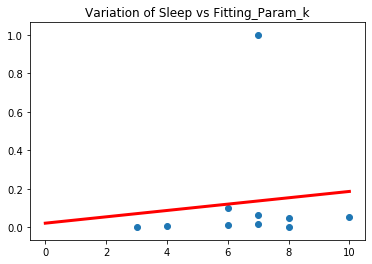

In [14]:
# Create basic plots relating k-values and the observed Happiness, Sleep and Stress values
create_plots_fits(merge, False)
linear_fit(merge, 'Fitting_Param_k', 'Happiness', False, None, max_value = 5)
linear_fit(merge, 'Fitting_Param_k', 'Stress', False, None, max_value = 5)
linear_fit(merge, 'Fitting_Param_k', 'Sleep', False, None, max_value = 10)


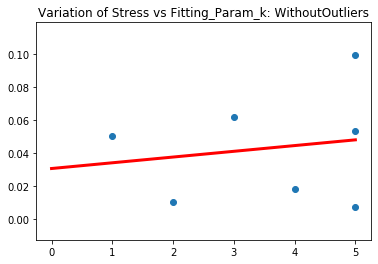

In [40]:
# Drop the participants whose k-value is an outlier 
# 5 & 7 chose almost all 1s, and 3 chose almost all 0s during the experiment
merge_without_outliers = merge[~merge['RefID'].isin([3, 5, 7])]
create_plots_fits(merge_without_outliers, False, 'WithoutOutliers')
linear_fit(merge_without_outliers, 'Fitting_Param_k', 'Happiness', False, 'WithoutOutliers',5)
linear_fit(merge_without_outliers, 'Fitting_Param_k', 'Sleep', False, 'WithoutOutliers',10)
linear_fit(merge_without_outliers, 'Fitting_Param_k', 'Stress', False, 'WithoutOutliers', 5)


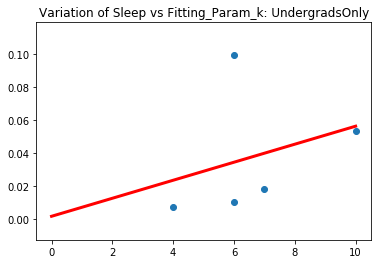

In [18]:
# Create plots corresponding to the condition that the participant is an undergraduate student
merge_undergrads_only = merge_without_outliers[merge_without_outliers['Degree'] == "Undergraduate"]
create_plots_fits(merge_undergrads_only, False, 'UndergradsOnly')
linear_fit(merge_undergrads_only, 'Fitting_Param_k', 'Happiness', False, 'UndergradsOnly', 5)
linear_fit(merge_undergrads_only, 'Fitting_Param_k', 'Stress', False, 'UndergradsOnly', 5)
linear_fit(merge_undergrads_only, 'Fitting_Param_k', 'Sleep', False, 'UndergradsOnly', 10)


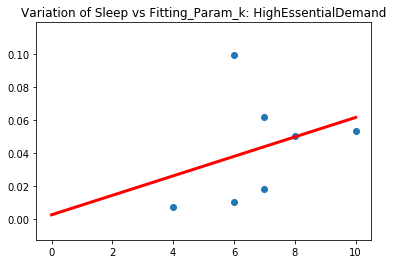

In [20]:
# Create plots corresponding to the condition that the participant spends more than 50% 
# of their monthly income on Essentials
merge_high_essential_demand = merge_without_outliers[merge_without_outliers['Essentials'] > 0.5]
create_plots_fits(merge_high_essential_demand, False, 'HighEssentialDemand')
linear_fit(merge_high_essential_demand, 'Fitting_Param_k', 'Happiness', False, 'HighEssentialDemand', 5)
linear_fit(merge_high_essential_demand, 'Fitting_Param_k', 'Stress', False, 'HighEssentialDemand', 5)
linear_fit(merge_high_essential_demand, 'Fitting_Param_k', 'Sleep', False, 'HighEssentialDemand', 10)




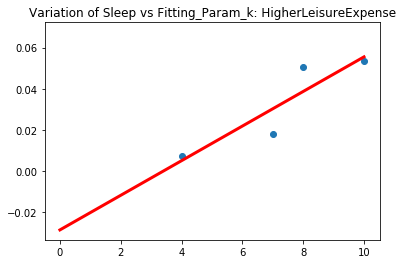

In [22]:
# Create plots corresponding to the condition that the participant spends more than 10% 
# of their monthly income on leisure activities
merge_high_leisure = merge_without_outliers[merge_without_outliers['Leisure'] > 0.1]
create_plots_fits(merge_high_leisure, False, 'HighLeisure')
linear_fit(merge_high_leisure, 'Fitting_Param_k', 'Happiness', False, 'HigherLeisureExpense', 5)
linear_fit(merge_high_leisure, 'Fitting_Param_k', 'Stress', False, 'HigherLeisureExpense', 5)
linear_fit(merge_high_leisure, 'Fitting_Param_k', 'Sleep', False, 'HigherLeisureExpense', 10)





In [24]:
measure = merge['Fitting_Param_k']

In [35]:
# Feature columns that may cause variation or clustering of calculated k-parameters
feature_columns = ['Age', 'Essentials', 'Happiness', 'Investments', 'Leisure',
       'Sleep', 'Stress']

In [36]:
# The Pearson-correlation coefficients are calculated 
# Associated p-values are reported
# As expected, the results are not significant since we are dealing with very few participants
import scipy.stats
for col in feature_columns:
    merge_without_outliers = merge_without_outliers.dropna(subset = [col])
    corr, p_val = scipy.stats.pearsonr(merge_without_outliers['Fitting_Param_k'], merge_without_outliers[col])
    print("Column: {}\t Corr: {} \tP-Val{}".format(col, corr, p_val))

Column: Age	 Corr: 0.1971588481148041 	P-Val0.6717599408697906
Column: Essentials	 Corr: 0.2837488706075032 	P-Val0.5374484013576115
Column: Happiness	 Corr: -0.42712174135521547 	P-Val0.3391855587466984
Column: Investments	 Corr: 0.2284894124409878 	P-Val0.6221500460590541
Column: Leisure	 Corr: -0.23265394515208926 	P-Val0.6156363600493444
Column: Sleep	 Corr: 0.3294194516132418 	P-Val0.47060322124716714
Column: Stress	 Corr: 0.1683937529723998 	P-Val0.7181617757488201
